In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
%matplotlib inline

In [3]:
def random_flip_array(rows, cols, p):
    '''
    Returns an array for which entries are 1 with probability p else zero.
    '''
    temp_1 = np.random.rand(rows,cols)
    temp_2 = p*np.ones((rows,cols))
    
    R = np.less(temp_1,temp_2)
    return R

In [4]:
def selected_progeny(repr_type,initial_state,m):
    '''
    Inputs:
    repr_type: 'asx' or 'sx'
    initial_state: PxG numpy array describing data of parents
    m: Mutation rate
    Returns
    progeny: PxG numpy array, Selected best half of progeny assuming duplication with mutations
    F: 2xP np array with first row containing fitness of each selected progeny.
    The second row contains fitness of every second progeny, for purposes of showing
    distribution pre selection, and selecting alternate progenies makes sure that array has P cols
    which is convenient for plotting animations later.
    P is population, G is Genome size
    '''

    P = len(initial_state)
    G = len(initial_state[0])
    
    if(repr_type=='asx'):
        dupl = np.vstack((initial_state,initial_state))
        R = random_flip_array(2*P,G,m)
    
        pre_sel_prog = np.logical_xor(dupl,R)
        del dupl, R
    else:
        couple_group = np.random.permutation(initial_state)
        pre_sel_prog = np.zeros((4,P//2,G))
        for i in range(4):
            R = random_flip_array(P//2, G, 0.5)
            Rbar = np.logical_not(R)
            pre_sel_prog[i] = np.logical_or(np.logical_and(couple_group[0::2],R),np.logical_and(couple_group[1::2],Rbar))
    
        pre_sel_prog = pre_sel_prog.reshape((1,2*P,G))[0]
    
        if(m!=0.0):
            R = random_flip_array(2*P,G,m)
            pre_sel_prog = np.logical_xor(pre_sel_prog,R)
    
        del initial_state, couple_group
    
    F_pre = np.sum(pre_sel_prog,axis=1)
    temp = np.c_[pre_sel_prog, F_pre]
    
    del pre_sel_prog, F_pre
    
    temp = temp[temp[:,-1].argsort()[::-1]] #Sort in decreasing fitness
    
    progeny = temp[0:P,:-1]!=0
    
    F = np.zeros((2,P))
    F[0] = temp[0:P,-1]
    F[1] = temp[0::2,-1]
    del temp
    
    return F, progeny

In [5]:
def fitness_evolution(repr_type,P,G,iterations,m,start_fitness):
    '''
    repr_type: 'asx' or 'sx'
    P: Population size
    G: Genome size
    iterations: Number of iterations
    m: Mutation rate
    start_fitness: Starting fitness
    
    Returns time vector, average fitness and stdev with time f_t
    F_t is in the following format: Even rows contain distribution of selected progenies
    Odd rows contain distribution pre selection, for purposes of animation
    '''
    F_t = np.zeros((2*iterations,P))
    parent = random_flip_array(P,G,start_fitness)

    for i in range(iterations):
        if(repr_type=='asx'):
            temp, progeny = selected_progeny('asx',parent,m)
        else:
            temp, progeny = selected_progeny('sx',parent,m)
        
        F_t[2*i] = temp[0]
        F_t[2*i+1] = temp[1]
        parent = progeny
        del progeny

    f_t = (1/G)*np.mean(F_t[0::2],axis=1)
    std_t = (1/G)*np.std(F_t[0::2],axis=1)
    t = np.arange(0,iterations,1)
    return t, f_t, F_t, std_t

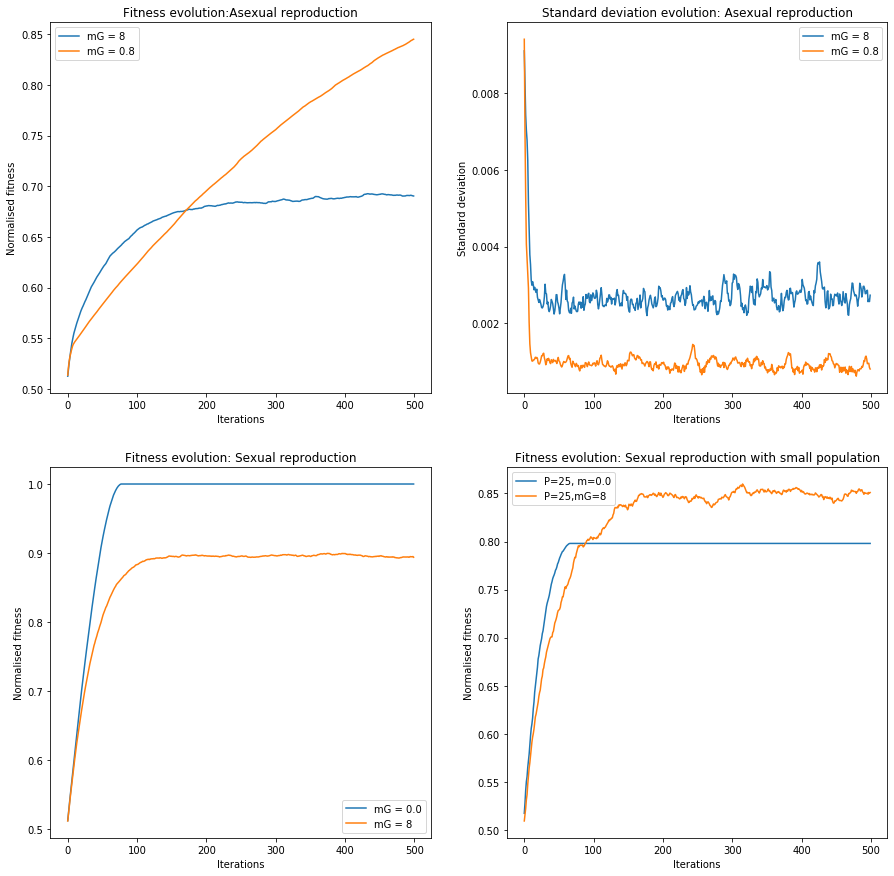

In [6]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

t1, f_t1, F_t1, std1 = fitness_evolution('asx',P=300,G=1000,iterations=500,m=0.008,start_fitness=0.5)
t1, f_t2, F_t2, std2 = fitness_evolution('asx',P=300,G=1000,iterations=500,m=0.0008,start_fitness=0.5)
t3, f_t3, F_t3, std3 = fitness_evolution('sx',P=300,G=1000,iterations=500,m=0.0,start_fitness=0.5)
t4, f_t4, F_t4, std4 = fitness_evolution('sx',P=300,G=1000,iterations=500,m=0.008,start_fitness=0.5)
t5, f_t5, F_t5, std5 = fitness_evolution('sx',P=20,G=1000,iterations=500,m=0.0,start_fitness=0.5)
t6, f_t6, F_t6, std6 = fitness_evolution('sx',P=20,G=1000,iterations=500,m=0.008,start_fitness=0.5)

ax[0,0].plot(t1,f_t1,label='mG = 8')
ax[0,0].plot(t1,f_t2,label='mG = 0.8')
ax[0,0].set_title('Fitness evolution:Asexual reproduction')
ax[0,0].set_xlabel('Iterations')
ax[0,0].set_ylabel('Normalised fitness')
ax[0,0].legend()

ax[0,1].plot(t1,std1,label='mG = 8')
ax[0,1].plot(t1,std2,label='mG = 0.8')
ax[0,1].set_title('Standard deviation evolution: Asexual reproduction')
ax[0,1].set_xlabel('Iterations')
ax[0,1].set_ylabel('Standard deviation')
ax[0,1].legend()

ax[1,0].plot(t3,f_t3,label='mG = 0.0')
ax[1,0].plot(t4,f_t4,label='mG = 8')
ax[1,0].set_title('Fitness evolution: Sexual reproduction')
ax[1,0].set_xlabel('Iterations')
ax[1,0].set_ylabel('Normalised fitness')
ax[1,0].legend()

ax[1,1].plot(t5,f_t5,label='P=25, m=0.0')
ax[1,1].plot(t6,f_t6,label='P=25,mG=8')
ax[1,1].set_title('Fitness evolution: Sexual reproduction with small population')
ax[1,1].set_xlabel('Iterations')
ax[1,1].set_ylabel('Normalised fitness')
ax[1,1].legend()

plt.savefig('Plots.png')
plt.show()

In [7]:
del f_t2, F_t2, std2, t4, f_t4, F_t4, std4, t5, f_t5, F_t5, std5, t6, f_t6, F_t6, std6

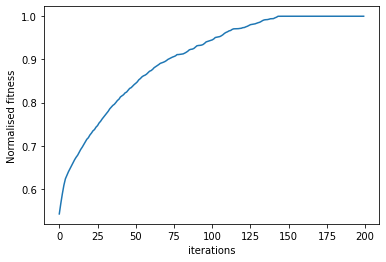

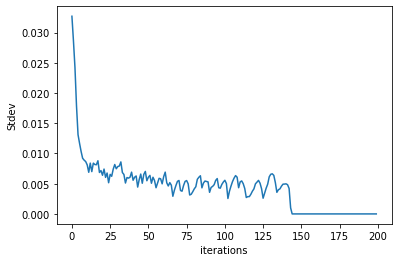

In [8]:
t_, f_t_, F_t_, std_ = fitness_evolution('asx',P=100,G=100,iterations=200,m=0.005,start_fitness=0.5)
plt.plot(t_,f_t_)
plt.xlabel('iterations')
plt.ylabel('Normalised fitness')
plt.show()
plt.plot(t_,std_)
plt.xlabel('iterations')
plt.ylabel('Stdev')
plt.show()

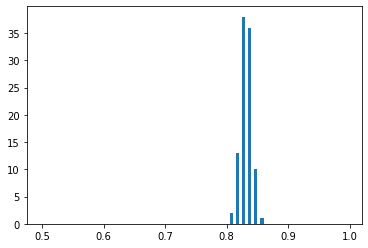

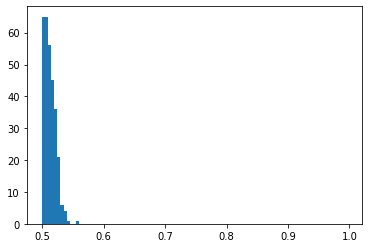

In [9]:
f_asx = (1/100)*F_t_
f_sx = (1/1000)*F_t3

def update(i,data,length):
    if i==length:
        a.event_source.stop()
    plt.cla()
    bins = np.arange(0.5,1,0.005)
    plt.hist(data[i],bins=bins)
    #plt.axis([0.5,1.0,0,10])

fig = plt.figure()
a = animation.FuncAnimation(fig,update,interval=200,fargs=(f_asx,200,))
a.save('asx.mp4')
del a

fig = plt.figure()
a = animation.FuncAnimation(fig,update,interval=200,fargs=(f_sx,500,))
a.save('sx.mp4')

In [10]:
from IPython.display import Video

In [11]:
Video('asx.mp4')

In [12]:
Video('sx.mp4')

In [13]:
%reset -f